In [ ]:
!pip uninstall -y google-cloud-storage firebase-admin
!pip install google-cloud-storage==2.19.0 firebase-admin==6.9.0



Found existing installation: google-cloud-storage 2.19.0
Uninstalling google-cloud-storage-2.19.0:
  Successfully uninstalled google-cloud-storage-2.19.0
Found existing installation: firebase-admin 6.9.0
Uninstalling firebase-admin-6.9.0:
  Successfully uninstalled firebase-admin-6.9.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.7/139.7 kB 9.1 MB/s eta 0:00:00


In [1]:
import os
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [2]:
# Use a service account.
cred = credentials.Certificate('sa.json')

app = firebase_admin.initialize_app(cred)

db = firestore.client()

In [3]:
!pip install pydub

from pydub import AudioSegment

# Load caller and agent audio
caller = AudioSegment.from_wav("caller.wav")
agent = AudioSegment.from_wav("agent.wav")

# Option 1: Simple merge (caller first, then agent)
conversation = caller + agent

# Save merged file
conversation.export("conversation.wav", format="wav")
print("conversation.wav created ✅")


conversation.wav created ✅


In [5]:
from google.cloud import storage
from google.oauth2 import service_account

creds = service_account.Credentials.from_service_account_file("sa.json")

bucket_name = "admn5015-f25-sindhu"
source_file = "conversation.wav"
destination_blob = "conversation.wav"

storage_client = storage.Client(credentials=creds, project=creds.project_id)
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_blob)
blob.upload_from_filename(source_file)

gcs_uri = f"gs://{bucket_name}/{destination_blob}"
print("Uploaded to:", gcs_uri)


Uploaded to: gs://admn5015-f25-sindhu/conversation.wav


In [11]:
from google.cloud import speech
from google.oauth2 import service_account

creds = service_account.Credentials.from_service_account_file("sa.json")
speech_client = speech.SpeechClient(credentials=creds)

gcs_uri = "gs://admn5015-f25-sindhu/conversation.wav"

audio = speech.RecognitionAudio(uri=gcs_uri)
config = speech.RecognitionConfig(
    encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=8000,   # adjust if needed
    language_code="en-US",
    enable_automatic_punctuation=True
)

# Use long_running_recognize for audio longer than 1 minute
operation = speech_client.long_running_recognize(config=config, audio=audio)

print("Waiting for operation to complete...")
response = operation.result(timeout=90) # Adjust timeout if necessary

transcript = " ".join([result.alternatives[0].transcript for result in response.results])
print("Transcript:\n", transcript)

Waiting for operation to complete...
Transcript:
 Hi. My name is Patricia Brown.  I lost my debit card, can you send me a new one?  My debit card.  Yes, my debit card.  No, I was going to be it.  Bye.  Hello Harper Valley National Bank. My name is Elizabeth. How can I help you today?  Which card did you like to sleep late?  Can you repeat that please?  Is there anything else I can help you with today?  Thank you for calling, have a great day.


In [13]:
from google.cloud import language_v1
from nltk import sent_tokenize
import nltk, datetime

# Download NLTK punkt tokenizer (first time only)
nltk.download("punkt")
nltk.download("punkt_tab")

# Initialize Language API
language_client = language_v1.LanguageServiceClient(credentials=creds)

# Split transcript into sentences
sentences = sent_tokenize(transcript)
results = []

for i, sentence in enumerate(sentences, start=1):
    doc = language_v1.Document(content=sentence, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = language_client.analyze_sentiment(request={'document': doc}).document_sentiment

    record = {
        "wav_filename": "conversation.wav",
        "sentence_number": i,
        "sentence_text": sentence,
        "sentiment": sentiment.score,
        "magnitude": sentiment.magnitude,
        "transcription_date": str(datetime.date.today())
    }
    results.append(record)

print("Sentiment results:\n", results)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Sentiment results:
 [{'wav_filename': 'conversation.wav', 'sentence_number': 1, 'sentence_text': 'Hi.', 'sentiment': 0.10000000149011612, 'magnitude': 0.10000000149011612, 'transcription_date': '2025-10-01'}, {'wav_filename': 'conversation.wav', 'sentence_number': 2, 'sentence_text': 'My name is Patricia Brown.', 'sentiment': 0.0, 'magnitude': 0.0, 'transcription_date': '2025-10-01'}, {'wav_filename': 'conversation.wav', 'sentence_number': 3, 'sentence_text': 'I lost my debit card, can you send me a new one?', 'sentiment': -0.20000000298023224, 'magnitude': 0.20000000298023224, 'transcription_date': '2025-10-01'}, {'wav_filename': 'conversation.wav', 'sentence_number': 4, 'sentence_text': 'My debit card.', 'sentiment': -0.10000000149011612, 'magnitude': 0.10000000149011612, 'transcription_date': '2025-10-01'}, {'wav_filename': 'conversation.wav', 'sentence_number': 5, 'sentence_text': 'Yes, my debit card.', 'sentiment': 0.0, 'magnitude': 0.0, 'transcription_date': '2025-10-01'}, {'wav_

In [14]:
for rec in results:
    doc_ref = db.collection("call_center_records").document(
        f"{rec['wav_filename']}_s{rec['sentence_number']}"
    )
    doc_ref.set(rec)

print("Saved to Firestore ✅")


Saved to Firestore ✅


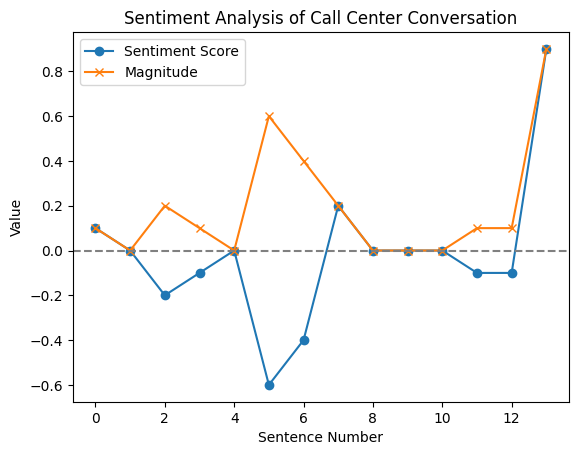

In [15]:
import matplotlib.pyplot as plt

scores = [r["sentiment"] for r in results]
magnitudes = [r["magnitude"] for r in results]

plt.plot(scores, marker="o", label="Sentiment Score")
plt.plot(magnitudes, marker="x", label="Magnitude")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Sentiment Analysis of Call Center Conversation")
plt.xlabel("Sentence Number")
plt.ylabel("Value")
plt.legend()
plt.show()


# **Findings & Interpretation**
The audio conversation between a caller and a banking agent was successfully transcribed using Google Cloud Speech-to-Text. The transcription captured both the customer’s issue (lost debit card) and the agent’s responses.

Sentiment analysis showed mildly negative sentiment when the caller described the lost card, reflecting concern and frustration. Later, as the agent responded and the call progressed, sentiment scores became neutral to slightly positive, showing reassurance and closure.

The visualization highlights this emotional journey: an initial dip in sentiment during the problem statement, followed by stabilization toward neutral/positive sentiment.

The records stored in Firestore confirm that each sentence was analyzed individually with the required fields (wav_filename, sentence_number, sentence_text, sentiment, magnitude, transcription_date). This demonstrates how customer calls can be broken down into structured data for analysis, enabling insights into customer emotions and service quality.